In [1]:
import scvi
import scanpy as sc
import anndata

/home/ec2-user/anaconda3/envs/shuonan_visualization/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scvi.__version__

'1.2.2.post2'

In [41]:

adata = anndata.read_h5ad('/home/ec2-user/SageMaker/output_dir/adata_sc_embedded.h5ad')

# load the original adata and subset!

In [46]:

origpath = '/home/ec2-user/SageMaker/our_data_LC_NE/preprocessed/adata_sc_pre.h5ad'
adata_orig = anndata.read_h5ad(origpath)
print(adata_orig.shape)
# origpath = '/home/ec2-user/SageMaker/our_data_LC_NE/adata_sc.h5ad'
# adata_orig = anndata.read_h5ad(origpath)
# print(adata_orig.shape)

(5040, 24343)


# only subset the same gene

## 1. get orthologus

In [34]:
import pandas as pd 
path_to_orthologus_csv = '/home/ec2-user/SageMaker/nicheformer/shaomai_playground/mouse_to_human.csv'
orthologus_csv = pd.read_csv(path_to_orthologus_csv)
orthologus_csv = orthologus_csv[orthologus_csv.hsapiens_homolog_ensembl_gene.notna()]
mouse_en_to_human_en = dict(zip(orthologus_csv.ensembl_gene_id, orthologus_csv.hsapiens_homolog_ensembl_gene))

In [47]:
adata.obs = adata_orig.obs.copy()

In [51]:
adata_orig.var=adata_orig.var.rename(index=mouse_en_to_human_en) # change ENSUMUS to ENSGO

## 2. remove duplicates

In [54]:
dup_indx = ~adata_orig.var.index.duplicated(keep='first')
adata_orig = adata_orig[:,dup_indx]

In [56]:
adata_orig.shape

(5040, 23911)

## 3. only keep the ones included in the model 

In [58]:
import anndata as ad
model = ad.read_h5ad('/home/ec2-user/SageMaker/nicheformer/data/model_means/model.h5ad')
keep_genes = [m in set(model.var.index) for m in adata_orig.var.index]
adata_orig = adata_orig[:, keep_genes]
adata_orig.shape. # (5040, 15661)

In [61]:
adata_orig = ad.concat([model, adata_orig], join='outer', axis=0)
adata_orig = adata_orig[1:].copy() # dropping the first observation 
adata_orig.shape. # (5040, 20310)

(5040, 20310)

In [62]:
adata_orig.shape, adata.shape

((5040, 20310), (5040, 512))

## 4. PCA

In [64]:
sc.pp.normalize_total(adata_orig)
sc.pp.log1p(adata_orig)
sc.tl.pca(adata_orig)


In [66]:
adata_orig.var_names

Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167',
       ...
       'ENSMUSG00000112117', 'ENSMUSG00000112148', 'ENSMUSG00000112276',
       'ENSMUSG00000113186', 'ENSMUSG00000114028', 'ENSMUSG00000114469',
       'ENSMUSG00000115424', 'ENSMUSG00000115432', 'ENSMUSG00000115529',
       'ENSMUSG00000115965'],
      dtype='object', length=20310)

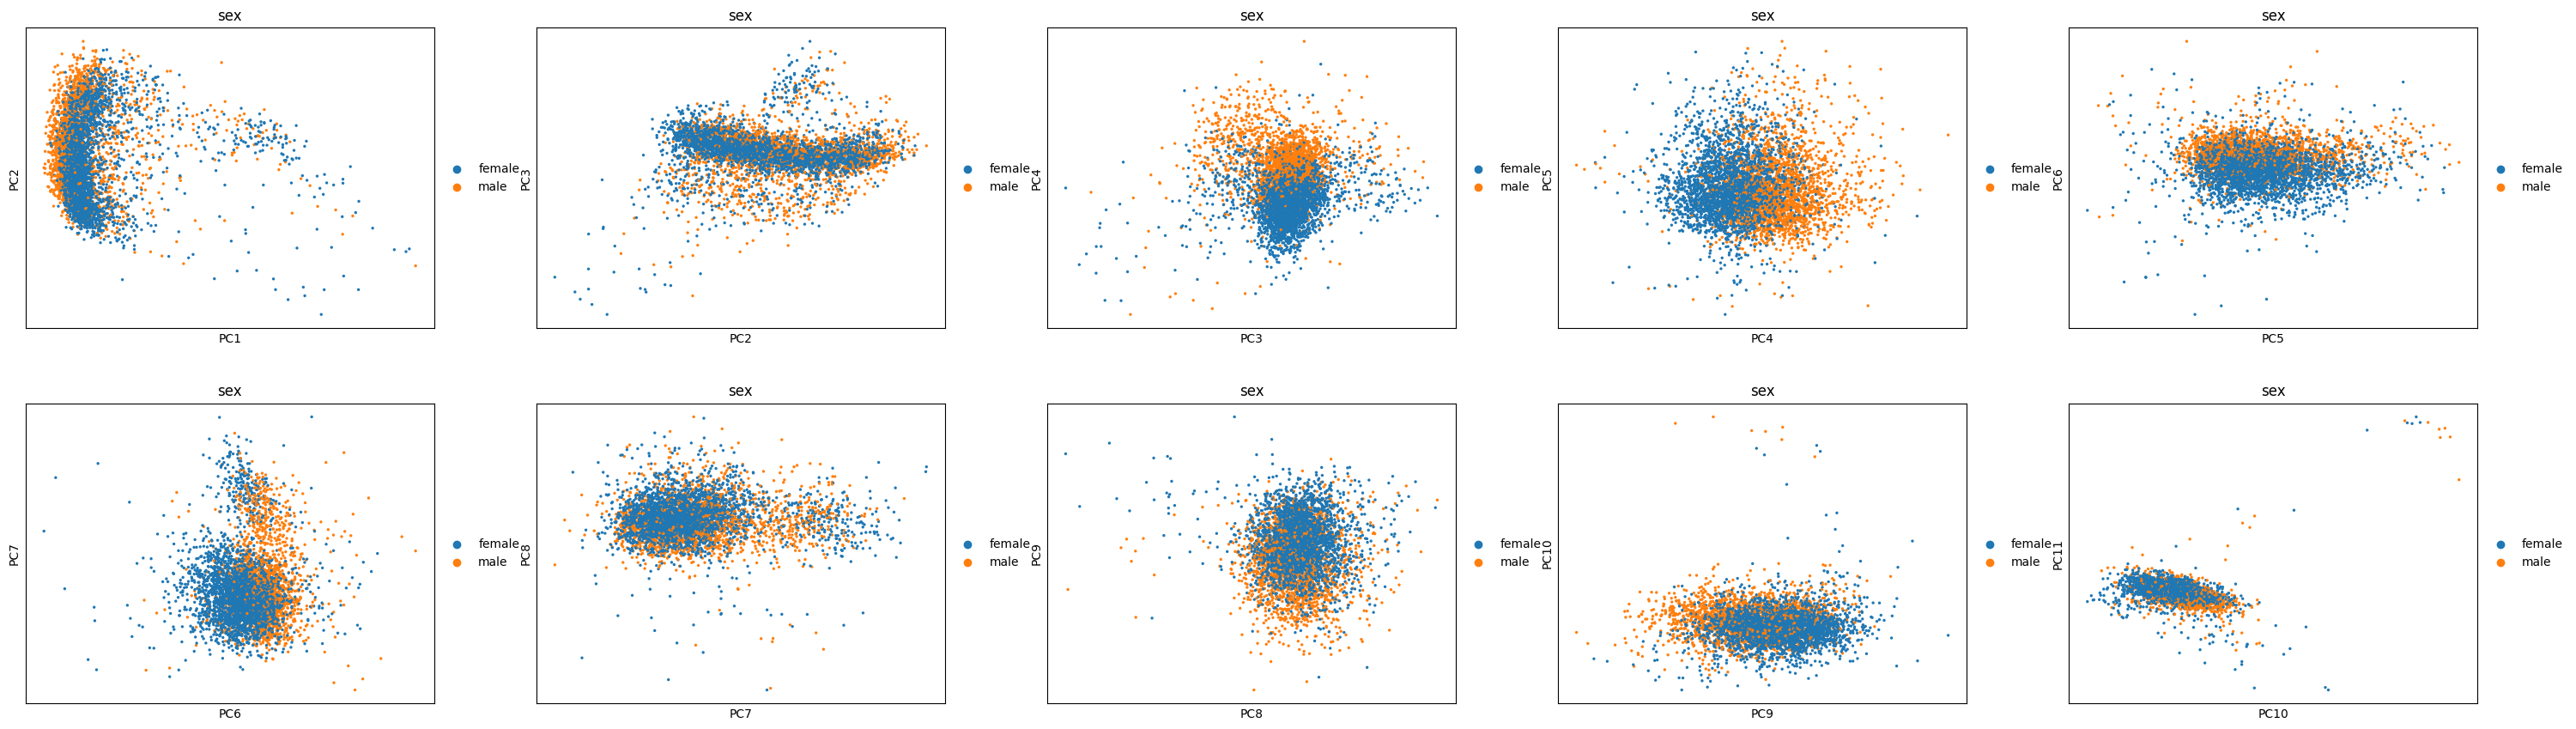

In [70]:
sc.pl.pca(adata_orig, dimensions = [(i,i+1) for i in range(10)],ncols=5,color = ['sex'])

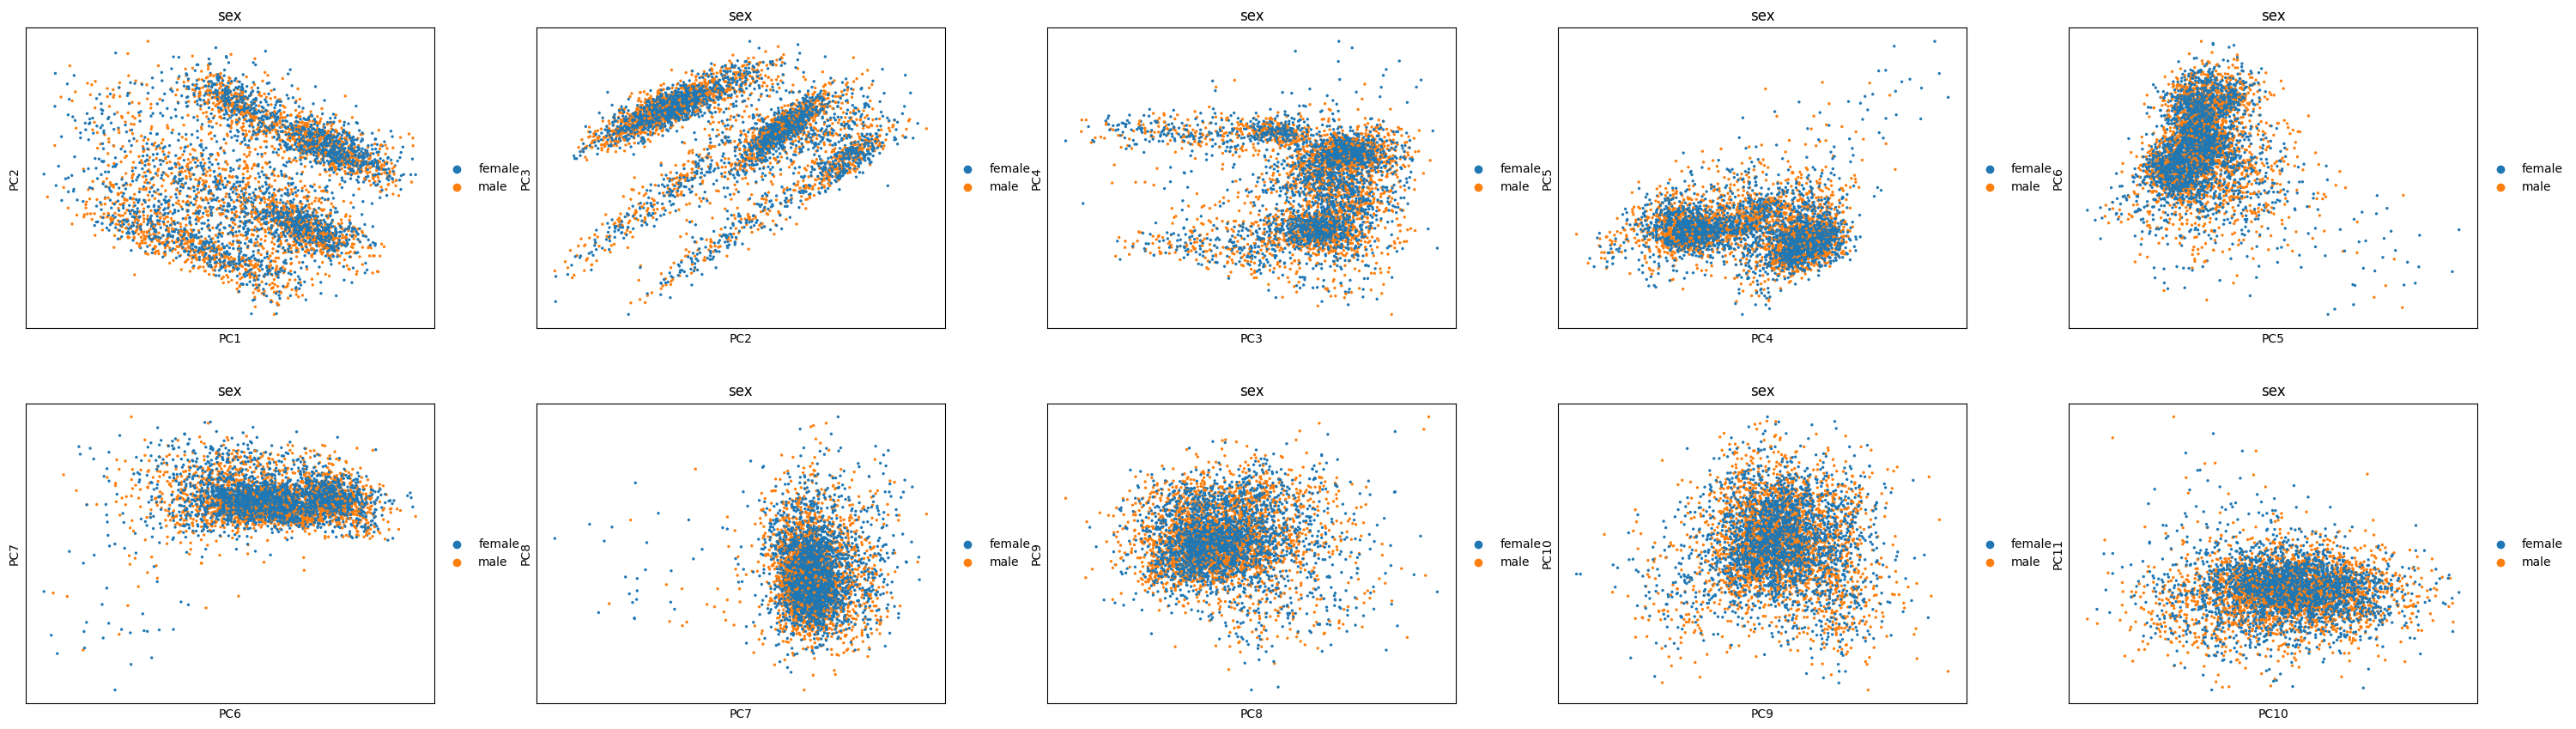

In [69]:
sc.tl.pca(adata)
sc.pl.pca(adata, dimensions = [(i,i+1) for i in range(10)],ncols=5,color = ['sex'])

## 5. umap

In [ ]:
sc.pp.neighbors(adata_orig)
sc.tl.umap(adata_orig)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

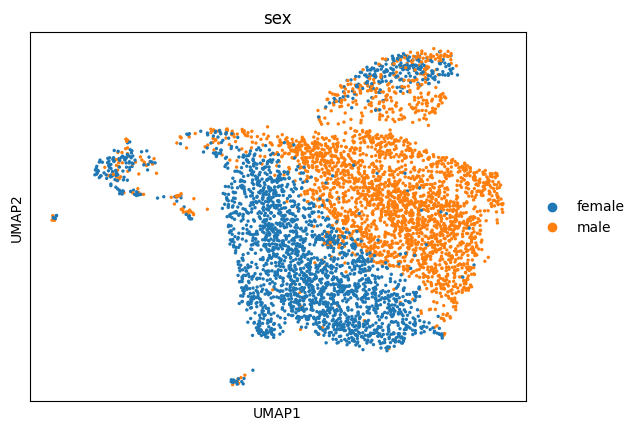

In [73]:
sc.pl.umap(adata_orig,color = ['sex'])

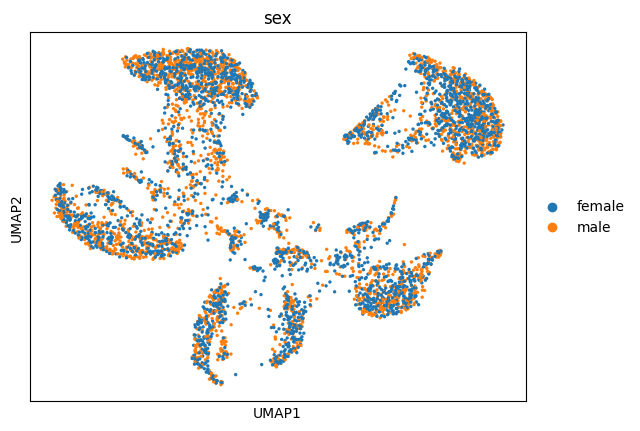

In [74]:
sc.pl.umap(adata,color = ['sex'])

## 6. clustering on umap X(

In [77]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, )
sc.tl.leiden(adata_orig, flavor="igraph", n_iterations=2)

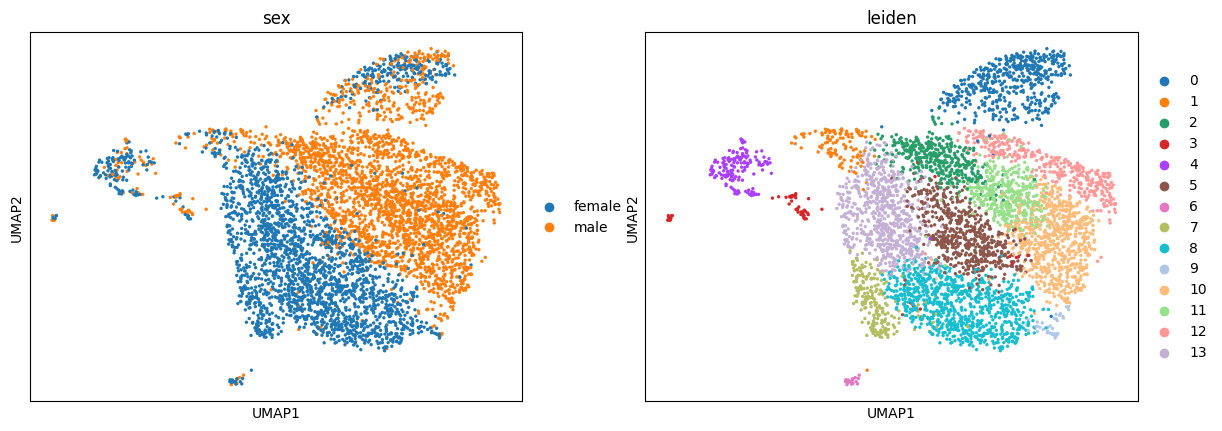

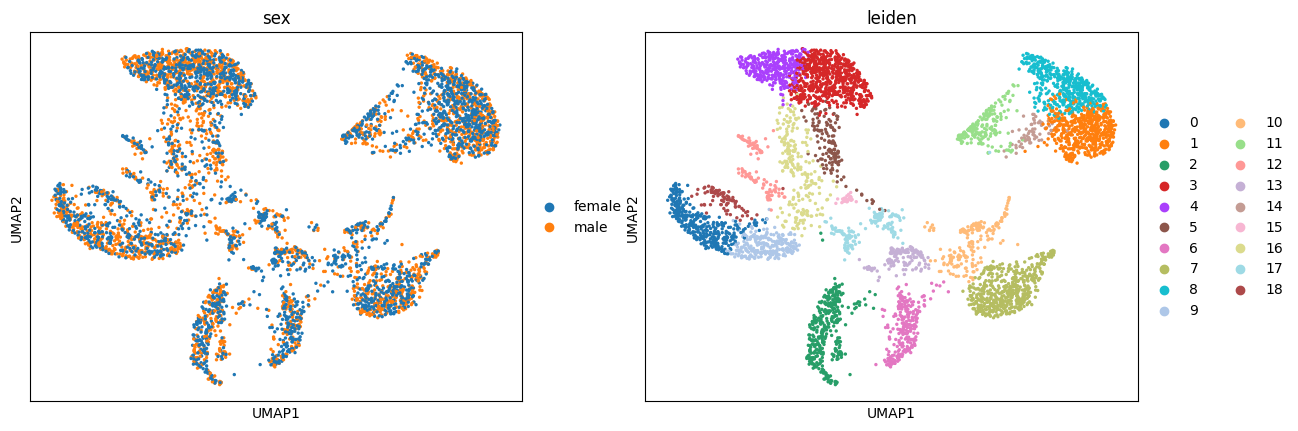

In [78]:
sc.pl.umap(adata_orig,color = ['sex','leiden'])
sc.pl.umap(adata,color = ['sex','leiden'])

## 7.clustering on pca
### a. leiden


In [98]:
import numpy as np

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])

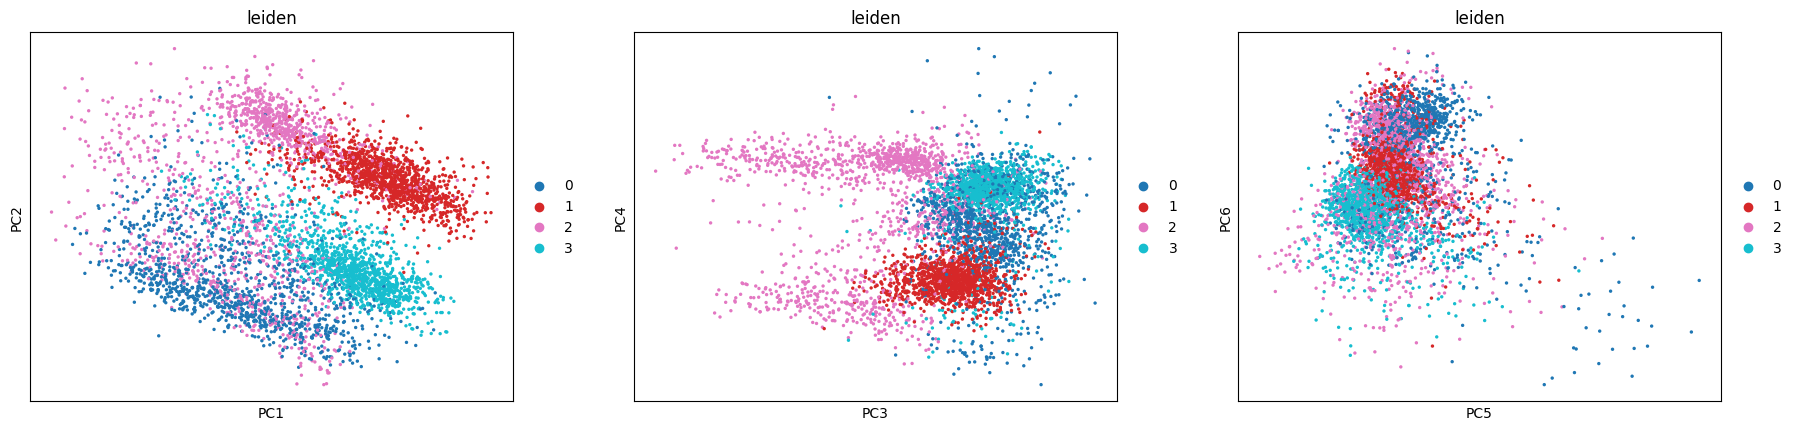

In [140]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.leiden(adata,resolution = 0.05, flavor="igraph",)
sc.pl.pca(adata,color = ['leiden'], dimensions = [(i,i+1) for i in np.arange(0,5,step=2)], ncols = 3, palette='tab10')

### b. kmeans

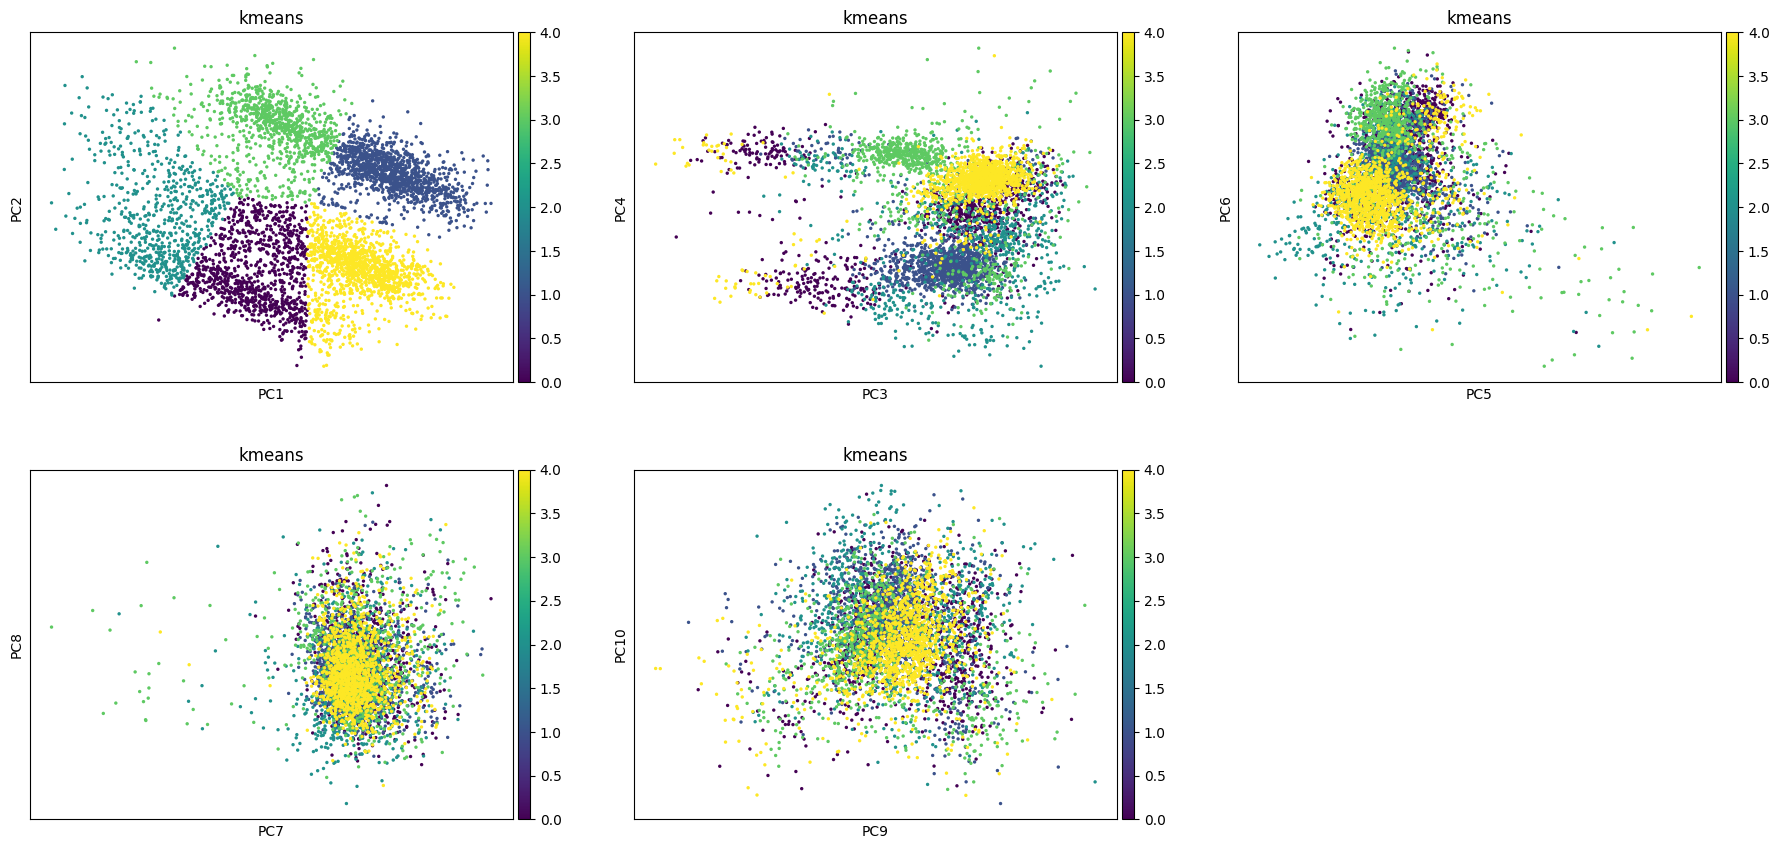

In [264]:
from sklearn.cluster import KMeans
total_k = 2
X_pca_totalk = adata.obsm['X_pca'][:, :total_k]
kmeans = KMeans(n_clusters=5, random_state=42,max_iter=1000)
adata.obs['kmeans'] = kmeans.fit_predict(X_pca_totalk)
sc.pl.pca(adata,color = ['kmeans'], dimensions = [(i,i+1) for i in np.arange(0,10,step=2)], ncols = 3)

## 8. DE genes

In [147]:
adata.shape, adata_orig.shape

((5040, 512), (5040, 20310))

In [149]:
adata.obs['leiden'].shape

(5040,)

In [150]:
adata_orig.obs['embedded_leiden'] = adata.obs['leiden']

In [151]:
sc.tl.rank_genes_groups(adata_orig, groupby='embedded_leiden', method='wilcoxon')

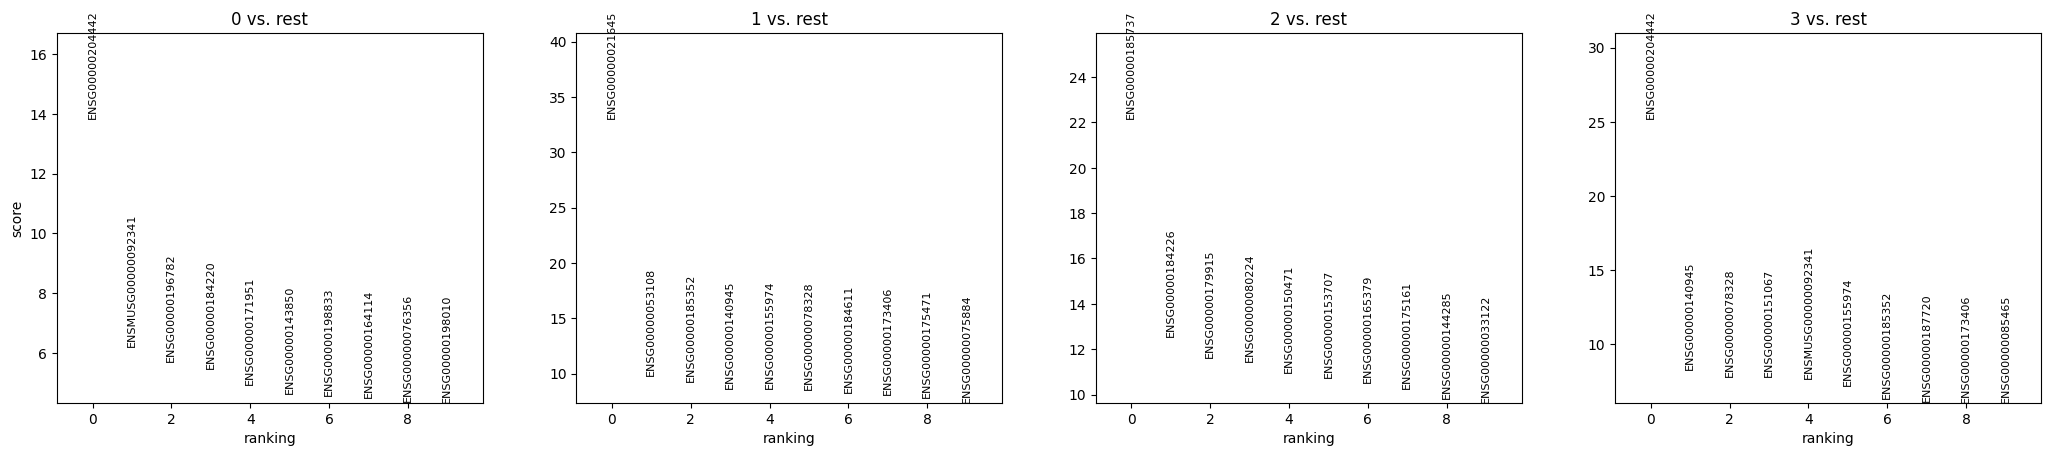

In [162]:
sc.pl.rank_genes_groups(adata_orig, n_genes=10, sharey=False)


In [242]:
top_genes_cluster_list = [adata_orig.uns['rank_genes_groups']['names'][str(k)][:5] for k in range(4)]

In [243]:
top_genes_cluster_list

[array(['ENSG00000204442', 'ENSMUSG00000092341', 'ENSG00000196782',
        'ENSG00000184220', 'ENSG00000171951'], dtype=object),
 array(['ENSG00000021645', 'ENSG00000053108', 'ENSG00000185352',
        'ENSG00000140945', 'ENSG00000155974'], dtype=object),
 array(['ENSG00000185737', 'ENSG00000184226', 'ENSG00000179915',
        'ENSG00000080224', 'ENSG00000150471'], dtype=object),
 array(['ENSG00000204442', 'ENSG00000140945', 'ENSG00000078328',
        'ENSG00000151067', 'ENSMUSG00000092341'], dtype=object)]

### get gene ID from ensemble genes 

In [159]:
from pyensembl import EnsemblRelease

In [160]:
data = EnsemblRelease(104, species='mus_musculus')    
data.index()

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/ec2-user/.cache/pyensembl/GRCm39/ensembl104/Mus_musculus.GRCm39.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/ec2-user/.cache/pyensembl/GRCm39/ensembl104/Mus_musculus.GRCm39.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/ec2-user/.cache/pyensembl/GRCm39/ensembl104/Mus_musculus.GRCm39.pep.all.fa.gz.pickle


In [210]:
# test 

ensemblid = 'ENSG00000204442'
dict_id = np.where(np.array(list(mouse_en_to_human_en.values())) == ensemblid)[0][0]

mouse_ensm = list(mouse_en_to_human_en.keys())[dict_id]
mouse_en_to_human_en[mouse_ensm'ENSMUSG00000079157'] == ensemblid # confirm
final_gene_name = data.gene_by_id(mouse_ensm).gene_name

In [258]:
def get_gene_name_from_orthologus_ensembleid(ensemblid):  # input shoudl be ENSGO**
    if g.startswith('ENSMUSG'):
        final_gene_name = data.gene_by_id(ensemblid).gene_name
        return(final_gene_name)
    dict_id = np.where(np.array(list(mouse_en_to_human_en.values())) == ensemblid)[0][0]
    mouse_ensm = list(mouse_en_to_human_en.keys())[dict_id]
    assert(mouse_en_to_human_en[mouse_ensm] == ensemblid ) # confirm)
    final_gene_name = data.gene_by_id(mouse_ensm).gene_name
    return(final_gene_name)

In [259]:
get_gene_name_from_orthologus_ensembleid('ENSG00000140945')

ValueError: Gene not found: ENSG00000140945

In [266]:
for i,k in enumerate(top_genes_cluster_list):
    print('\n',i)
    for g in k:
        print(get_gene_name_from_orthologus_ensembleid(g))


 0
Fam155a
Malat1
Maml3
Cmss1
Scg2

 1
Nrxn3
Fstl4
Hs6st3
Cdh13
Grip1

 2
Nrg3
Pcdh9
Nrxn1
Epha6
Adgrl3

 3
Fam155a
Cdh13
Rbfox1
Cacna1c
Malat1


## our genes 